In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from layers import FreeSpacePropagation
import time
import pandas as pd
import cv2
from cxlayers import AngularSpectrum, ImageResizing, ImageToElectricField, ImageBinarization, CxMO, CxD2NNFaradayRotation, CxD2NNIntensity, D2NNMNISTDetector, Polarizer, GGG


plt.rcParams["font.size"]=18

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [3]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test == i)][0:test_num]

Metal device set to: Apple M1


2022-04-05 13:00:13.675603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-05 13:00:13.675841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-05 13:00:13.755460: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-05 13:00:13.795355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


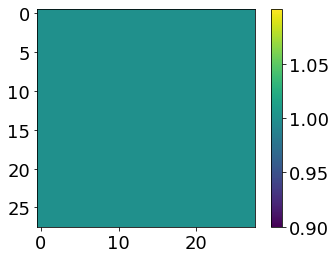

In [2]:
inputs = tf.keras.layers.Input((28, 28))
x = ImageToElectricField((28, 28))(inputs)
x = CxD2NNIntensity((28, 28))(x)

model = tf.keras.Model(inputs, x)

image = np.ones((10, 28, 28))
pred = model.predict(image)
plt.imshow(pred[0,:,:])
plt.colorbar()

In [44]:
class MOD2NN(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # 複数モデルを入れ子にすることもOK
        self.model = self.create_model()
        # トラッカーを用意する（訓練、テスト共通で良い）
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.loss_tracker = tf.keras.metrics.SparseCategoricalCrossentropy()
        self.accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        self.accuracy_tracker = tf.keras.metrics.SparseCategoricalAccuracy()

    def create_model(self):
        shape = (40, 40)
        inputs = tf.keras.layers.Input((28, 28))
        x = ImageResizing(shape)(inputs)
        x = ImageBinarization(0.5, 0, 1)(x)
        x = ImageToElectricField(shape)(x)
        x = CxMO(shape)(x)
        x = AngularSpectrum(shape, 531e-9, 0.5e-3, d=2.0e-6,n=1.0, method='expand')(x)
        x = CxD2NNIntensity(shape)(x)
        x = D2NNMNISTDetector(10)(x)
        return tf.keras.models.Model(inputs, x)

    # なくてもエラーは出ないが、訓練・テスト間、エポックの切り替わりで
    # トラッカーがリセットされないため、必ずmetricsのプロパティをオーバーライドすること
    # self.reset_metrics()はこのプロパティを参照している
    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy]

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            pred = self.model(x)
            loss_value = self.loss_object(y, pred)
            accuracy_value = self.accuracy(y, pred)
        # 全体（self）に対する偏微分か、特定モデル（self.model）に対する微分かは場合により変わる
        # このケースではどちらでも同じだが、GANでは使い分ける必要がある
        grads = tape.gradient(loss_value, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # エポックの切り替わりのトラッカーのリセットは、self.reset_metrics()で自動的に行われる
        self.loss_tracker.update_state(y, pred)
        self.accuracy_tracker.update_state(y, pred)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.accuracy_tracker.result()
        }

    def test_step(self, data):
        x, y = data

        pred = self.model(x)
        loss = self.loss_object(y, pred)

        # 訓練・テストの切り替わりのトラッカーのリセットは、self.reset_metrics()で自動的に行われる
        self.loss_tracker.update_state(loss)
        return {
            "loss": self.loss_tracker.result()
        }

In [45]:
model =MOD2NN()
model.compile(optimizer=tf.keras.optimizers.Adam())
model.fit(x_train, y_train, batch_size=64, epochs=10)

Epoch 1/10


2022-04-03 20:58:45.307114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 32/938 [>.............................] - ETA: 7:53 - loss: 2.4210 - accuracy: 0.1094

KeyboardInterrupt: 

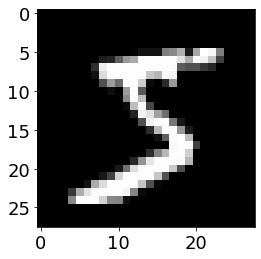

In [6]:
plt.imshow(x_train[0,:,:], cmap="binary")